# San Joaquin Valley Township Precipitation Data and Stations

Related links:

* For the documentation about this dataset, its source, how to download, and the features of interest, please refer to our [Well Completion Reports Dataset](/doc/assets/precipitation.md) documentation.
* For the explanations about the Public Land Survey System Township Range, please refer to our [Public Land Survey System](../assets/plss_sanjoaquin_riverbasin.md) documentation.
* For the explanations on how we transform point measurements of precipitation by weather stations into township precipitation estimates, please refer to our [Transforming Point Values into Township Values](doc/etl/from_point_to_region_values.md) documentation.


In [1]:
import sys
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt
import altair as alt
from lib.precipitation_v2 import PrecipitationDataset
from lib.viz import view_year_side_by_side, map_exploration

By initializing the PrecipitationDataset class, it automatically:
* scraps the web to retrieve the precipitation data for the state of California (default is between 2013 and 2022)
* scraps the web to retrieve the geospatial data of the precipitation stations in California

In [3]:
precipitation_dataset = PrecipitationDataset()

Here is an overview of the monthly precipitation data scrapped from the web.

In [4]:
precipitation_dataset.data_df

,STATION_ID,STATION_NAME,AVERAGE_YEARLY_PRECIPITATION,YEAR
0,ALT,ALTURAS RS,0.842500,2013
1,APU,ANGWIN PACIFIC UNION COL,3.312000,2013
2,ASM,ASH MOUNTAIN,1.281667,2013
3,ATW,ATWELL CAMP,2.128333,2013
4,ABR,AUBERRY 2 NW,1.635000,2013
...,...,...,...,...
1762,WVR,WEAVERVILLE RS,3.830000,2022
1763,WPT,WEST POINT,6.287500,2022
1764,WDL,WOODLAND 1 WNW,3.055000,2022
1765,YSV,YOSEMITE HEADQUARTERS,5.312500,2022


By default the precipitation data are collected for the following years:

In [5]:
list(precipitation_dataset.data_df.YEAR.unique())

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

Here is an overview of the precipitation stations geospatial data scrapped from the web.

In [6]:
precipitation_dataset.map_df

,STATION,STATION_ID,LATITUDE,LONGITUDE,COUNTY,geometry
0,ACTON,ACN,34.445999,-118.199997,LOS ANGELES,POINT (-118.20000 34.44600)
1,ADIN MOUNTAIN,ADM,41.237000,-120.792000,MODOC,POINT (-120.79200 41.23700)
2,ADIN RS,ADN,41.194000,-120.944000,MODOC,POINT (-120.94400 41.19400)
3,AGNEW PASS,AGP,37.726631,-119.141731,MADERA,POINT (-119.14173 37.72663)
4,AL SMITH CANAL,ASA,40.483925,-121.855339,SHASTA,POINT (-121.85534 40.48392)
...,...,...,...,...,...,...
1194,YUBA RIVER NEAR MARYSVILLE,MRY,39.175724,-121.524963,YUBA,POINT (-121.52496 39.17572)
1195,YUBA RIVER NEAR SMARTVILLE,YRS,39.235172,-121.274124,YUBA,POINT (-121.27412 39.23517)
1196,YUCCA VALLEY,YUC,34.123001,-116.407997,SAN BERNARDINO,POINT (-116.40800 34.12300)
1197,ZAPATO CHINO,ZPC,36.015999,-120.292999,FRESNO,POINT (-120.29300 36.01600)


In [7]:
precipitation_dataset.preprocess_map_df(features_to_keep=["STATION_ID", "COUNTY", "geometry"])
precipitation_dataset.merge_map_with_data(how="inner", dropkeys=True, dropna=True)
precipitation_dataset.map_df

,COUNTY,geometry,STATION_NAME,AVERAGE_YEARLY_PRECIPITATION,YEAR
0,MODOC,POINT (-120.55000 41.50000),ALTURAS RS,0.842500,2013
1,MODOC,POINT (-120.55000 41.50000),ALTURAS RS,0.605833,2014
2,MODOC,POINT (-120.55000 41.50000),ALTURAS RS,0.975833,2015
3,MODOC,POINT (-120.55000 41.50000),ALTURAS RS,1.120833,2016
4,MODOC,POINT (-120.55000 41.50000),ALTURAS RS,1.241667,2017
...,...,...,...,...,...
1663,SISKIYOU,POINT (-122.63300 41.70000),YREKA,0.934167,2018
1664,SISKIYOU,POINT (-122.63300 41.70000),YREKA,1.562500,2019
1665,SISKIYOU,POINT (-122.63300 41.70000),YREKA,0.785000,2020
1666,SISKIYOU,POINT (-122.63300 41.70000),YREKA,0.940833,2021


Let's look at California's precipitation recording station locations compared to the San Joaquin Valley townships for the year 2021

In [8]:
map_exploration(precipitation_dataset.map_df, feature="AVERAGE_YEARLY_PRECIPITATION", year=2021)

Next, based on the precipitation station points, we compute Voronoi Diagram with the Thiessen Polygon for each station

In [9]:
precipitation_dataset.compute_areas_from_points()

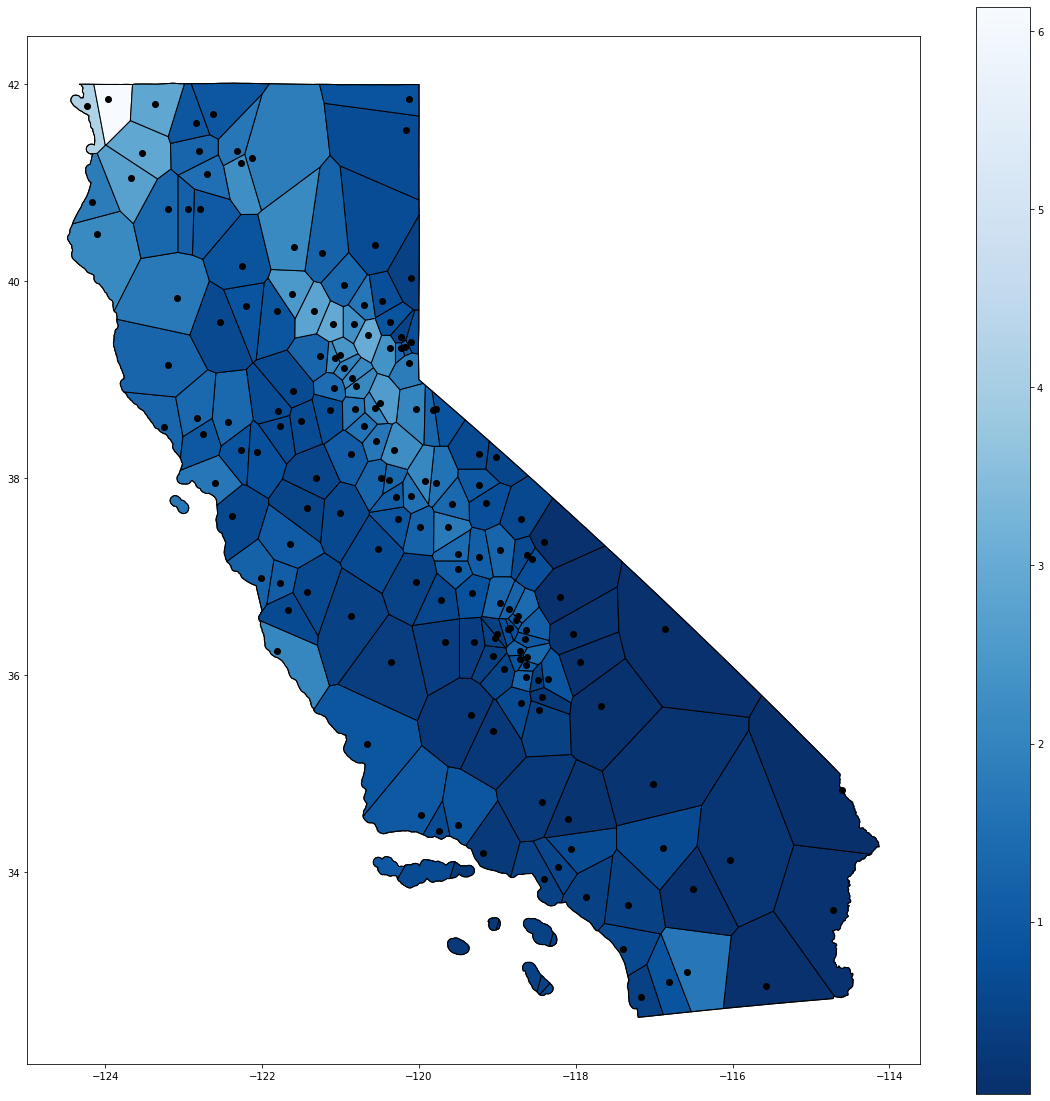

In [10]:
fig, ax = plt.subplots(figsize=(20,20))
precipitation_dataset.map_df[precipitation_dataset.map_df["YEAR"]==2021].plot(ax=ax, column="AVERAGE_YEARLY_PRECIPITATION",
                                                                              edgecolor='black', linewidth = 1, cmap="Blues_r", legend=True)
precipitation_dataset.map_df[precipitation_dataset.map_df["YEAR"]==2021].points.plot(ax=ax, facecolor="black", edgecolor='black', linewidth = 1)
precipitation_dataset.ca_boundaries.plot(ax=ax, facecolor="none", edgecolor='black', linewidth = 1, cmap=None, legend=None)
plt.show()

Then we clip the data to the San Joaquin Valley boundaries and overlay the Township boundaries

In [11]:
precipitation_dataset.overlay_township_boundries()
precipitation_dataset.map_df

,COUNTY,STATION_NAME,AVERAGE_YEARLY_PRECIPITATION,YEAR,points,TOWNSHIP_RANGE,geometry
0,SANTA BARBARA,JUNCAL DAM,1.511667,2020,POINT (-119.50000 34.48300),T10N R22W,"POLYGON ((-119.27754 34.93089, -119.27754 34.9..."
1,KERN,BAKERSFIELD AIRPORT,0.641667,2020,POINT (-119.05400 35.43400),T10N R22W,"POLYGON ((-119.21812 34.93089, -119.27754 34.9..."
2,SANTA BARBARA,JUNCAL DAM,1.511667,2020,POINT (-119.50000 34.48300),T10N R23W,"POLYGON ((-119.33206 34.93092, -119.33206 34.9..."
3,KERN,BAKERSFIELD AIRPORT,0.641667,2020,POINT (-119.05400 35.43400),T10N R23W,"POLYGON ((-119.33206 34.98432, -119.33206 34.9..."
4,SANTA BARBARA,JUNCAL DAM,1.511667,2020,POINT (-119.50000 34.48300),T11N R23W,"POLYGON ((-119.34127 34.98864, -119.38475 34.9..."
...,...,...,...,...,...,...,...
7031,SACRAMENTO,SACRAMENTO WB CITY,1.330000,2018,POINT (-121.50000 38.58300),T07N R06E,"POLYGON ((-121.29788 38.42362, -121.26066 38.4..."
7032,SACRAMENTO,SACRAMENTO WB CITY,1.330000,2018,POINT (-121.50000 38.58300),T07N R07E,"POLYGON ((-121.26066 38.45565, -121.24674 38.4..."
7033,SACRAMENTO,FOLSOM DAM - FOLSOM POINT (DYKE 8),1.670833,2018,POINT (-121.12972 38.69305),T07N R07E,"POLYGON ((-121.26066 38.45565, -121.26066 38.4..."
7034,SACRAMENTO,FOLSOM DAM - FOLSOM POINT (DYKE 8),1.670833,2018,POINT (-121.12972 38.69305),T08N R08E,"POLYGON ((-121.07591 38.51033, -121.03862 38.5..."


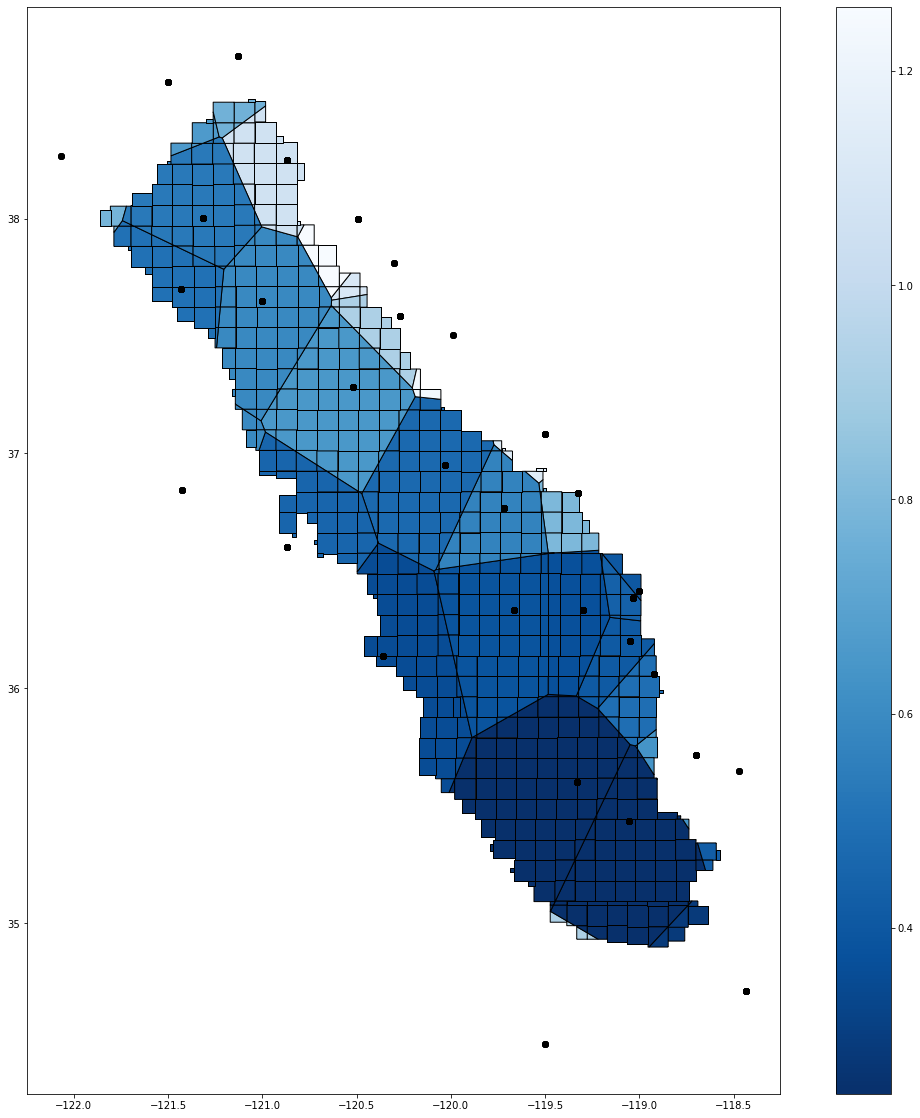

In [12]:
fig, ax = plt.subplots(figsize=(20,20))
precipitation_dataset.map_df[precipitation_dataset.map_df["YEAR"]==2021].plot(ax=ax, column="AVERAGE_YEARLY_PRECIPITATION",
                                                                              edgecolor='black', linewidth = 1, cmap="Blues_r", legend=True)
precipitation_dataset.map_df[precipitation_dataset.map_df["YEAR"]==2021].points.plot(ax=ax, facecolor="black", edgecolor='black', linewidth = 1)
plt.show()

Because of the way we [transform point measurements of precipitation by weather stations into township precipitation estimates](doc/etl/from_point_to_region_values.md), although there are 16 weather stations in the San Joaquin Valley, a total of 33 stations are use to estimate the county-townships precipitations. Looking at their value average yearly precipitation measurement per year, we get.

In [13]:
station_precipitation_per_year_df = precipitation_dataset.map_df[["YEAR", "AVERAGE_YEARLY_PRECIPITATION", "STATION_NAME"]].drop_duplicates()
alt.Chart(station_precipitation_per_year_df).mark_bar().encode( x="YEAR:N",y='AVERAGE_YEARLY_PRECIPITATION:Q', color='STATION_NAME:N')

alt.Chart(...)

We then compute the precipitation value at the Township level. As some townships cross several Voronoïd areas, for every year, for every Township we take the mean of the values of the Voronoïd areas crossing that Township.

In [14]:
precipitation_dataset.aggregate_areas_within_townships(group_by_features=["TOWNSHIP_RANGE", "YEAR"],
                                                      feature_to_aggregate_on="AVERAGE_YEARLY_PRECIPITATION")
precipitation_dataset.map_df

,TOWNSHIP_RANGE,YEAR,geometry,AVERAGE_YEARLY_PRECIPITATION
0,T01N R02E,2020,"POLYGON ((-121.78743 37.94165, -121.78743 37.9...",0.933333
1,T01N R03E,2020,"POLYGON ((-121.58654 37.88186, -121.69654 37.8...",0.796667
2,T01N R04E,2020,"POLYGON ((-121.47695 37.88115, -121.58708 37.8...",0.796667
3,T01N R05E,2020,"POLYGON ((-121.47750 37.88306, -121.47750 37.8...",0.796667
4,T01N R06E,2020,"POLYGON ((-121.36722 37.97096, -121.25671 37.9...",0.874167
...,...,...,...,...
473,T32S R26E,2018,"POLYGON ((-119.23510 35.17999, -119.12777 35.1...",0.329167
474,T32S R27E,2018,"POLYGON ((-119.12837 35.17977, -119.02128 35.1...",0.329167
475,T32S R28E,2018,"POLYGON ((-119.02170 35.17954, -118.91457 35.1...",0.329167
476,T32S R29E,2018,"POLYGON ((-118.91470 35.18006, -118.80566 35.1...",0.329167


In [15]:
view_year_side_by_side(precipitation_dataset.map_df, feature="AVERAGE_YEARLY_PRECIPITATION", title="Average yearly precipitation")

alt.ConcatChart(...)

The dataset is ready for output

In [16]:
precipitation_dataset.prepare_output_from_map_df()
precipitation_dataset.output_dataset_to_csv("../assets/outputs/precipitations.csv")
precipitation_dataset.output_df

,TOWNSHIP_RANGE,YEAR,AVERAGE_YEARLY_PRECIPITATION
0,T01N R02E,2020,0.933333
1,T01N R03E,2020,0.796667
2,T01N R04E,2020,0.796667
3,T01N R05E,2020,0.796667
4,T01N R06E,2020,0.874167
...,...,...,...
473,T32S R26E,2018,0.329167
474,T32S R27E,2018,0.329167
475,T32S R28E,2018,0.329167
476,T32S R29E,2018,0.329167
